# 回帰

### Q1. Airbnbの宿泊料金データの準備
[Airbnb](https://www.airbnb.com)は民泊マッチングサービスの最大手であり，様々な民泊施設の空き状況，宿泊料金を確認し，予約を行うことができる．[Inside Airbnb](http://insideairbnb.com/get-the-data.html)では，Airbnbに掲載された民泊物件のデータが公開されており，宿泊料金を含めた各民泊の各種物件情報を取得することができる．以後の課題では，Inside Airbnbに公開された東京の民泊データを用いて，宿泊料金以外の民泊の物件情報から宿泊料金を予測する回帰モデルを構築する．

以下の手順に従って，分析に用いるデータを準備せよ：
1. Inside Airbnbから最新の東京（Tokyo, Kanto, Japan）の``listings.csv.gz``ファイル（csvの圧縮ファイル）をダウンロードし``pandas``のデータフレームに格納せよ．なお，データフレームの変数名は``listing_df``とせよ．
2. ``listing_df``には，2万を超える民泊物件に関して，物件ID（``id``）や料金（``price``）など106個の属性（特徴量）の情報が格納されている．``data/airbnb``ディレクトリの``features.tsv``ファイルには，各属性の意味と今回の課題で用いるか否かのフラグが記されている．``features.tsv``ファイルを用いて，データフレーム``listing_df``から課題で用いない属性を削除せよ．

In [1]:
import pandas as pd

In [2]:
# 対象とする属性のリストを作成
feature_df = pd.read_table("../data/airbnb/features.tsv", header=0, sep='\t')
target_features = list(feature_df[feature_df.is_used == 1].feature)

# 対象とする属性のみデータを読み込む
listing_df = pd.read_csv("../data/airbnb/listings.csv.gz", usecols=target_features)

# 最初の5県を表示
listing_df.head()

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,is_location_exact,property_type,...,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
0,NaN,NaN,NaN,f,3.0,t,t,Shibuya Ku,t,Apartment,...,10.0,10.0,9.0,t,f,f,strict_14_with_grace_period,f,f,0.18
1,within a few hours,100%,88%,t,1.0,t,t,Sumida Ku,f,Apartment,...,10.0,9.0,10.0,t,f,f,moderate,f,f,1.57
2,within a few hours,100%,82%,f,2.0,t,t,Nerima Ku,f,Apartment,...,9.0,9.0,9.0,t,f,f,strict_14_with_grace_period,f,f,1.18
3,within a day,100%,93%,t,3.0,t,t,Setagaya Ku,t,Apartment,...,10.0,10.0,10.0,t,f,f,moderate,f,f,1.39
4,within a few hours,100%,82%,f,2.0,t,t,Nerima Ku,f,Apartment,...,10.0,9.0,10.0,t,f,f,strict_14_with_grace_period,f,f,1.12


### Q2. データ加工（1/3）：型変換
データフレーム``listing_df``に格納されたデータの中には，計算機が処理しにくい形式のデータが混じっている．例えば，属性``price``は1泊あたりの料金（日本円）を意味するが，「ドルマーク（＄）」や「カンマ（,）」が文字列として含まれているため数値として扱えない．``listing_df``にある下記属性について，指定されたデータ形式に変換し，その結果を``listing_df_v2``に格納せよ．

* ``price``：float型
* ``clearning_fee``：float型
* ``security_deposit``：float型
* ``host_response_rate``：%記号を取り除いた数字（float型）
* ``host_acceptance_rate``：%記号を取り除いた数字（float型）
* ``host_is_superhost``："t"を1，"f"を0とするint型
* ``host_has_profile_pic``："t"を1，"f"を0とするint型
* ``host_identity_verified``："t"を1，"f"を0とするint型
* ``is_location_exact``："t"を1，"f"を0とするint型
* ``requires_license``："t"を1，"f"を0とするint型
* ``instant_bookable``："t"を1，"f"を0とするint型
* ``is_business_travel_ready``："t"を1，"f"を0とするint型
* ``require_guest_profile_picture``："t"を1，"f"を0とするint型
* ``require_guest_phone_verification``："t"を1，"f"を0とするint型

In [3]:
listing_df_v2 = listing_df.assign(
    price = lambda df: df['price'].str.replace("$", "").str.replace(",", "").astype(float),
    cleaning_fee = lambda df: df['cleaning_fee'].str.replace("$", "").str.replace(",", "").astype(float),
    security_deposit = lambda df: df['security_deposit'].str.replace("$", "").str.replace(",", "").astype(float),
    host_response_rate = lambda df: df['host_response_rate'].str.replace("%", "").astype(float),
    host_acceptance_rate = lambda df: df['host_acceptance_rate'].str.replace("%", "").astype(float),
    host_is_superhost = lambda df: df['host_is_superhost'].apply(lambda x: 1 if x == 't' else 0),
    host_has_profile_pic = lambda df: df['host_is_superhost'].apply(lambda x: 1 if x == 't' else 0),
    host_identity_verified = lambda df: df['host_is_superhost'].apply(lambda x: 1 if x == 't' else 0),
    is_location_exact = lambda df: df['host_is_superhost'].apply(lambda x: 1 if x == 't' else 0),
    requires_license = lambda df: df['host_is_superhost'].apply(lambda x: 1 if x == 't' else 0),
    instant_bookable = lambda df: df['host_is_superhost'].apply(lambda x: 1 if x == 't' else 0),
    is_business_travel_ready = lambda df: df['host_is_superhost'].apply(lambda x: 1 if x == 't' else 0),
    require_guest_profile_picture = lambda df: df['host_is_superhost'].apply(lambda x: 1 if x == 't' else 0),
    require_guest_phone_verification = lambda df: df['host_is_superhost'].apply(lambda x: 1 if x == 't' else 0), 
)

### Q3. データの確認（1/2）
``listing_df_v2``を用いて1泊あたりの宿泊費の基本的な記述統計量（データ数，平均，標準偏差，最小値，最大値，四分位点）を求めよ．また，1泊あたりの宿泊費のヒストグラムを生成し，宿泊費の分布を把握せよ．

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
sns.set_style('ticks')
%matplotlib inline

In [5]:
# listing_df_v2.price.describe()では見にくいので
pd.DataFrame(listing_df_v2.price.describe()).T

,count,mean,std,min,25%,50%,75%,max
price,15352.0,26241.576668,76363.443264,0.0,6952.0,11979.0,20001.0,1000053.0


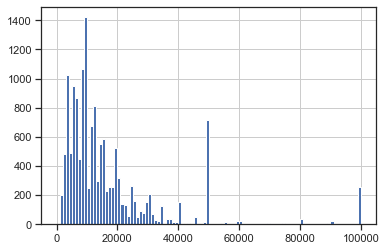

In [6]:
# 1泊10万円以下の物件の分布
listing_df_v2[listing_df_v2.price < 100000].price.hist(bins=100)

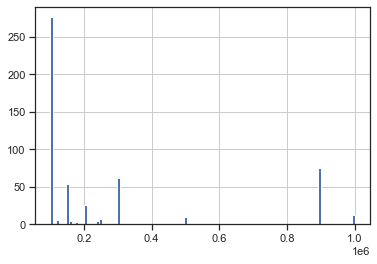

In [7]:
# 1泊10万円以上のの物件の分布
listing_df_v2[listing_df_v2.price >= 100000].price.hist(bins=100)

### Q4. データの確認（2/2）
``listing_df_v2``に含まれる欠損値（空の値：NaN）の数を，各属性ごとに求めよ．

In [8]:
listing_df_v2.isnull().sum()

host_response_time                  1062
host_response_rate                  1062
host_acceptance_rate                 460
host_is_superhost                      0
host_listings_count                   11
host_has_profile_pic                   0
host_identity_verified                 0
neighbourhood_cleansed                 0
is_location_exact                      0
property_type                          0
room_type                              0
accommodates                           0
bathrooms                              4
bedrooms                              24
beds                                  43
bed_type                               0
amenities                              0
price                                  0
security_deposit                    1247
cleaning_fee                         689
minimum_nights                         0
maximum_nights                         0
number_of_reviews                      0
review_scores_rating                2640
review_scores_ac

In [9]:
# Non-Nullの数ならinfoメソッドでも確認可能
listing_df_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15352 entries, 0 to 15351
Data columns (total 37 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   host_response_time                14290 non-null  object 
 1   host_response_rate                14290 non-null  float64
 2   host_acceptance_rate              14892 non-null  float64
 3   host_is_superhost                 15352 non-null  int64  
 4   host_listings_count               15341 non-null  float64
 5   host_has_profile_pic              15352 non-null  int64  
 6   host_identity_verified            15352 non-null  int64  
 7   neighbourhood_cleansed            15352 non-null  object 
 8   is_location_exact                 15352 non-null  int64  
 9   property_type                     15352 non-null  object 
 10  room_type                         15352 non-null  object 
 11  accommodates                      15352 non-null  int64  
 12  bath

### Q5. データ加工（2/3）：カテゴリ変数のダミー変数変換
回帰分析等の機械学習を用いる際，天気（例：晴れ，曇り，雨，雪）などのカテゴリ変数（質的データ変数）を特徴量として用いたい場合，カテゴリ変数を**ダミー変数**に変換することで対応する．例えば，下記のようなデータフレームがあるとする．

|ID|日付|天気|売上|
|---:|---:|---:|---:|
|1|xxx|晴れ|3500|
|2|xxx|曇り|1500|
|3|xxx|雨|800|
|4|xxx|晴れ|2200|

このデータフレームの``天気``変数をダミー変数化したデータフレームは下記の通りである．

|ID|日付|天気_晴れ|天気_曇り|天気_雨|売上|
|---:|---:|---:|---:|---:|---:|
|1|xxx|1|0|0|3500|
|2|xxx|0|1|0|1500|
|3|xxx|0|0|1|800|
|4|xxx|1|0|0|2200|

データフレーム``listing_df_v2``中の下記属性について，ダミー変数化を行い，その結果を``listing_df_v3``とせよ．

In [10]:
dummy_targets = ["host_response_time", "neighbourhood_cleansed",
                 "property_type", "room_type", "bed_type", "cancellation_policy"]

In [11]:
listing_df_v3 = pd.get_dummies(listing_df_v2, columns=dummy_targets)

### Q6. データ加工（3/3）：カテゴリ変数のダミー変数変換2
下記のように，データフレーム``listing_df_v3``の``amenities``属性には，1つの属性にカンマ区切りで複数の要素が格納されている．

| price | ... | amenities | ... |
|---:|---:|:---|---:|
|10000| ... | toilet, WiFi, BBQ grill| ... |
|15000| ... | toilet, WiFi, Air purifier| ... |

``amenities``属性に含まれる各要素をダミー変数化し，``listing_df_v3``を以下のような形式に変換せよ．その結果をデータフレーム``listing_df_v4``に格納せよ．


| price | ... | toilet | WiFi | BBQ grill | Air purifier | ... |
|---:|---:|---:|---:|---:|---:|---:|
|10000| ... | 1 | 1 | 1 | 0 | ... |
|15000| ... | 1 | 1 | 0 | 1 | ... |

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer

ml_binarizer = MultiLabelBinarizer()


listing_df_v4 = listing_df_v3.pipe(
    lambda df: pd.DataFrame(
        ml_binarizer.fit_transform(df['amenities'].str.replace("[{}\"]", "").str.strip().str.split(",")),
        columns=ml_binarizer.classes_,
        index=df.index
    )
).join( # amenityラベルの情報をもつデータフレームを元のlisting_dfと結合
    listing_df_v3
).drop(
    'amenities', axis=1
).drop( # カラム名が空文字の列を除去
    '', axis=1
)

### Q7. 欠損値対応（1/2）：行削除
Q4で確認したように，現実世界のデータは欠損値を含むことがしばしばある．欠損値は理由があって値が欠損しているのであれば，欠損していること自体に「意味がある」として，その情報をデータ解析に積極的に活用するべきである．しかし，学習モデルによっては，欠損値を含むデータの学習を行うことができない．そのため，欠損値を何らかの方法で事前に処理する必要がある．

欠損値の対応としては，下記のような方法などが提案されている．
* 欠損値の除去
    * 欠損値を含む行をデータから除外する方法（リストワイズ除去）
    * 欠損値を含む列をデータから除外する方法（ペアワイズ除去）
* 欠損値の補完
    * 欠損値をそれを含む列データの代表値（平均や中央値など）で埋める方法
    * 欠損値をそれを含む行と類似する行データ（k近傍データ）の平均値で埋める方法
    * 多重代入法
    
Q6で準備したデータには欠損値が含まれている．当該データから欠損値を含む行を除外せよ（リストワイズ除去を実行せよ）．

In [13]:
listing_df_v5 = listing_df_v4.dropna(how='any')

### Q8 ホールドアウト法
ホールドアウト法は，データ全体を一定の割合で訓練データと評価データに分け，分割されたデータを用いてモデルの学習と評価を行う方法である．

Q7で準備したデータを7対3の割合で訓練データと評価データに分割し，それらデータを用いて1泊あたりの宿泊費``price``を予測する線形回帰（単純な重回帰）モデルを構築せよ．さらに，課題Q8で用意した評価データを用いて，構築したモデルの精度評価を行え．

なお，この課題では，何も考えずにすべての特徴量を学習・評価に利用せよ．また，評価指標は下記のMAE（Mean Absolute Error：平均絶対誤差），RMSE（Root Mean Square Error：二乗平均平方根誤差）を用いよ．

$$
MAE = \frac{1}{n}\sum^n_i |y_i - \hat{y}_i| \\
RMSE = \sqrt{\frac{1}{n}\sum^n_i (y_i - \hat{y}_i)^2}
$$

In [14]:
from sklearn.model_selection import train_test_split

X = listing_df_v5.drop('price', axis=1).values
y = listing_df_v5['price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=77)

In [15]:
import numpy as np
from sklearn.metrics import mean_squared_error 

def rmse(y_predict, y_test):
    ''' RMSEは誤差を2乗するので，MAEに比べて大きな誤差を強調しやすい
    '''
    mse = mean_squared_error(y_predict, y_test)
    return np.sqrt(mse)

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

y_predict = linear_regressor.predict(X_test)
print("MAE =", mean_absolute_error(y_predict, y_test))
print("RMSE =", rmse(y_predict, y_test))

MAE = 27477.347299924946
RMSE = 79360.52396287947


### Q9. 交差検証
Q8で行ったホールドアウト法は，分割したデータに偏りがある場合，特定のデータに最適化された学習・評価が行われてしまうという欠点がある．この問題に対応する方法の1つが **交差検証法（Cross Validation）** である．交差検証法はデータをK個に分割し，そのうちの1つを評価用データ，残るK−1個を訓練データとした学習・評価をK回行い，得られた評価結果の平均値を最終的な評価指標として用いる方法である．

Q7で構築したデータセットを5分割交差検証法を用いて，1泊あたりの宿泊費``price``を予測する線形回帰（単純な重回帰）モデルを構築し，構築した予測モデル（平均の）MAEとRMSEを計算せよ．

#### cross_validate関数を使う場合

In [17]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

# K-Fold で汎化性能を評価する
k_fold = KFold(n_splits=5, shuffle=True, random_state=77)

# 評価する指標
score_funcs = {
    #'MAE': 'neg_mean_absolute_error',
    #'RMSE': 'neg_root_mean_squared_error',
    'MAE': make_scorer(mean_absolute_error),
    'RMSE': make_scorer(rmse),
}

# Cross Validation で検証する
X = listing_df_v5.drop('price', axis=1).values
y = listing_df_v5['price'].values
scores = cross_validate(linear_regressor, X, y, cv=k_fold, scoring=score_funcs)

# 得られた指標を出力する
print('MAE =', np.mean(scores['test_MAE']))
print('RMSE =', np.mean(scores['test_RMSE']))

MAE = 27282.785384867224
RMSE = 68772.75374588804


#### cross_validate関数を使わない場合

In [18]:
# K-Fold で汎化性能を評価する
k_fold = KFold(n_splits=5, shuffle=True, random_state=77)

linear_regressor = LinearRegression()
X = listing_df_v5.drop('price', axis=1).values
y = listing_df_v5['price'].values

scores = {'RMSE': [], 'MAE': []}
for indices_train, indices_test in k_fold.split(X):
    X_train, y_train = X[indices_train], y[indices_train]
    X_test, y_test = X[indices_test], y[indices_test]
    
    linear_regressor.fit(X_train, y_train)
    y_predict = linear_regressor.predict(X_test)
    
    scores['MAE'].append(mean_absolute_error(y_predict, y_test))
    scores['RMSE'].append(rmse(y_predict, y_test))    
    
print('MAE =', np.mean(scores['MAE']))
print('RMSE =', np.mean(scores['RMSE']))

MAE = 27282.785384867224
RMSE = 68772.75374588804


### Q10. 外れ値処理
Q4で確認したように，``listings.csv.gz``ファイルのデータには異常に大きな値や本来あり得ない値（例：宿泊費ゼロ），すなわち**外れ値**が含まれている．データの分布に基づきデータの解釈や予測モデルの構築を行う統計処理・機械学習では，外れ値の影響を受けやすい．そのため，前処理として外れ値を適切に処理することが重要である．

外れ値の検出方法としては様々なものが提案されているが，その1つとして四分位範囲を用いたものがある．この方法では，第1四分位点（$Q_{1/4}$）から第3四分位点（$Q_{3/4}$）の範囲を四分位範囲（IQR）としたとき，

$$ 
x < Q_{1/4} - 1.5 * IQR \\  
x \ge Q_{3/4}+1.5*IQR $$

の範囲にある$x$，つまり四分位範囲の1.5倍の範囲外にある$x$を外れ値として見なす．1泊あたりの宿泊料金``price``が，先の条件を満たすもしくは値がゼロであるもの外れ値と見なし，それらを含む行を除いたデータをデータフレーム``listing_df_v6``に格納せよ．また，``listing_df_v6``を用いて，Q9と同様のことを行え．

In [19]:
def remove_price_outliers(df):
    # 第1，第3四分位点
    Q1 = df.price.quantile(.25)
    Q3 = df.price.quantile(.75)

    # 外れ値範囲を算出
    IQR = Q3 - Q1
    upper_threshold = Q3 + 1.5 * IQR
    lower_threshold = Q1 - 1.5 * IQR

    # 宿泊料金の四分位範囲の1.5の範囲外にあるデータを除外
    new_df = df[ (df.price <= upper_threshold) & (df.price >= lower_threshold)]

    # 宿泊料金がゼロのデータを除外
    new_df = new_df[new_df.price != 0]
    
    return new_df

In [20]:
listing_df_v6 = remove_price_outliers(listing_df_v5)

In [21]:
pd.DataFrame(listing_df_v6.price.describe()).T

,count,mean,std,min,25%,50%,75%,max
price,9639.0,12289.53574,7812.875929,1177.0,6543.0,9975.0,15982.0,39043.0


In [22]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

# Cross Validation で検証する
X = listing_df_v6.drop('price', axis=1).values
y = listing_df_v6['price'].values

linear_regressor = LinearRegression()
scores = cross_validate(linear_regressor, X, y, cv=k_fold, scoring=score_funcs)

# 得られた指標を出力する
print('MAE =', np.mean(scores['test_MAE']))
print('RMSE =', np.mean(scores['test_RMSE']))

MAE = 3977.0798977859495
RMSE = 5565.675964781117


### Q11. 分散による特徴量選択
与えられたデータの特徴量（属性）には，予測モデルの構築に寄与しないものが多く含まれている．特徴量が大量にある場合，予測性能の低下を招くだけでなく，
* 学習にかかる計算コストが大きくなる，
* 学習そのものがうまく進まなくなる（例：次元の呪い）
* モデルの解釈が難しくなる

といった問題も生じる．このような問題に対応するため，有効な特徴量のみを残したまま，特徴量を減らす**特徴選択**が行われることがある．

特徴選択には
* Filter法：目的変数と説明変数（特徴量）の関係性だけを評価して，関連性の低い説明変数を取り除く（例：相関係数，ANOVA，相互情報量，カイ二乗係数）
* Wrapper法：特徴量の部分集合を用いてモデルの訓練を繰り返し行いながら，性能向上に寄与する特徴量を選択する
* Embedded法：モデルの学習と同時に予測に用いる特徴量を自動的に選択する（例：Lasso回帰）

の3つの方法に大別される．しかし，これらの特徴選択法を適用する前提として，分散がゼロあるいはサンプル大半で値が同じになる特徴量は，汎化性能を低下させる可能性があり，予測に寄与しないとして除外することがある．例えば今回の課題であれば，``toilet``という属性の値の99%が1（トイレあり）で残り1%がゼロ（トイレなし）であったケースなどである．

データフレーム``listing_df_v6``から，分散がゼロの特徴量，あるいは値の99%が同じ値である特徴量を除外し，その結果をデータフレーム``listing_df_v7``に格納せよ．

#### 分散がゼロの特徴量の削減

In [23]:
from sklearn.feature_selection import VarianceThreshold

variance_selector = VarianceThreshold(threshold=0.00)

target_data = listing_df_v6.drop('price', axis=1)
target_features = target_data.columns
variance_selector.fit(target_data)

selected_features = list(target_features[variance_selector.get_support()])
listing_df_v7 = listing_df_v6[['price'] + selected_features]

print("Original feature num: {}".format(listing_df_v6.shape[1]))
print("Selected feature num: {}".format(listing_df_v7.shape[1]))

Original feature num: 287
Selected feature num: 271


#### 値が99%同じ特徴量の削減

In [24]:
selection_flag = listing_df_v7.quantile(.99) - listing_df_v7.quantile(.0) != 0
selected_features = list(selection_flag[selection_flag].index)
listing_df_v7 = listing_df_v7[selected_features]

print("Selected feature num: {}".format(listing_df_v7.shape[1]))

Selected feature num: 146


#### 多重共線度への対応（変数間の相関が高い変数の削減）

#### 学習・評価

In [25]:
X = listing_df_v7.drop('price', axis=1).values
y = listing_df_v7['price'].values

linear_regressor = LinearRegression()
scores = cross_validate(linear_regressor, X, y, cv=k_fold, scoring=score_funcs)

# 得られた指標を出力する
print('MAE =', np.mean(scores['test_MAE']))
print('RMSE =', np.mean(scores['test_RMSE']))

MAE = 3989.954114630361
RMSE = 5569.651657520546


### Q12. 目的変数と説明変数の相関分析
特徴量選択の方法の1つであるフィルター法として，目的変数と説明変数（特徴量）との相関係数が大きいものを優先的に採用する方法がある．相関係数による特徴量選択を行うために，``price``属性とその他の属性の相関係数を求め，その上位30件を表示せよ．

In [26]:
corrs = dict(listing_df_v7.corr()['price'])
corrs.pop('price')

sorted(corrs.items(), key=lambda x: abs(x[1]), reverse=True)[:30]

[('accommodates', 0.5899773254731174),
 ('beds', 0.3634470934384575),
 ('cleaning_fee', 0.36268840788000156),
 ('room_type_Entire home/apt', 0.33730439471296736),
 ('bedrooms', 0.30473913336502934),
 ('room_type_Private room', -0.24336260049438516),
 ('room_type_Shared room', -0.21371137964491776),
 ('Private entrance', 0.2038852174720435),
 ('TV', 0.1851228439383846),
 ('property_type_Hostel', -0.17919847538158792),
 ('Lock on bedroom door', -0.1656759510764242),
 ('Kitchen', 0.16517992064403839),
 ('Private living room', 0.14578780876090383),
 ('Shampoo', 0.14346481166957775),
 ('host_acceptance_rate', 0.14045666619826058),
 ('Dishes and silverware', 0.13902865067835937),
 ('Essentials', 0.13083494876743995),
 ('Washer', 0.1291580280324384),
 ('translation missing: en.hosting_amenity_49', -0.12383574096423614),
 ('Patio or balcony', 0.12365957023298667),
 ('Iron', 0.12145449572698734),
 ('Dishwasher', 0.12019055758808843),
 ('translation missing: en.hosting_amenity_50', -0.1187232834

### Q13. 相関係数による特徴量選択
``listing_df_v7``における``price``値の予測モデルの構築において，相関係数に基づく特徴量選択を行い，相関係数が大きい上位k件の特徴量を用いて線形回帰モデルを構築することを考える．選択する特徴量の個数をk=1から1ずつ増やしていった際の，学習時間，MAE，RMSEの変化を折れ線グラフで図示せよ．

In [27]:
from sklearn.feature_selection import SelectKBest, f_regression

def linear_regression_with_feature_selection(X, y, feature_num=100):
    selector = SelectKBest(score_func=f_regression, k=feature_num) 
    selector.fit(X, y)

    # 選択した特徴量の列のみ取得
    X_new = selector.transform(X)

    linear_regressor = LinearRegression()
    scores = cross_validate(linear_regressor, X_new, y, cv=k_fold, scoring=score_funcs)

    results = {}
    results['fit_time'] = np.mean(scores['fit_time'])
    results['MAE'] = np.mean(scores['test_MAE'])
    results['RMSE'] = np.mean(scores['test_RMSE'])
    return results

In [28]:
X = listing_df_v7.drop('price', axis=1).values
y = listing_df_v7['price'].values
max_feature_num = X.shape[1]

fit_times = []
MAEs = []
RMSEs = []
for i in range(max_feature_num):
    feature_num = i + 1
    results = linear_regression_with_feature_selection(X, y, feature_num=feature_num)
    fit_times.append(results['fit_time'])
    MAEs.append(results['MAE'])
    RMSEs.append(results['RMSE'])

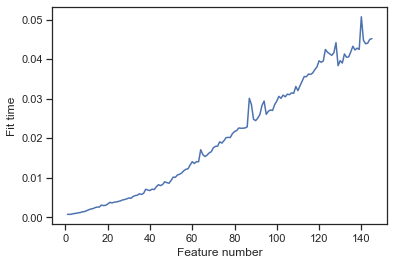

In [29]:
ax = sns.lineplot(x=np.arange(max_feature_num)+1, y=fit_times)
ax.set_xlabel('Feature number')
ax.set_ylabel('Fit time')
plt.show()

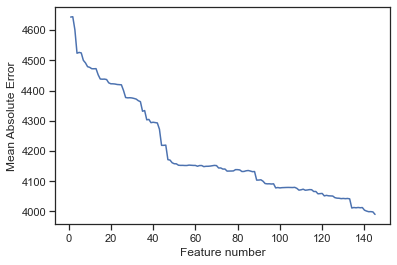

In [30]:
ax = sns.lineplot(x=np.arange(max_feature_num)+1, y=MAEs)
ax.set_xlabel('Feature number')
ax.set_ylabel('Mean Absolute Error')
plt.show()

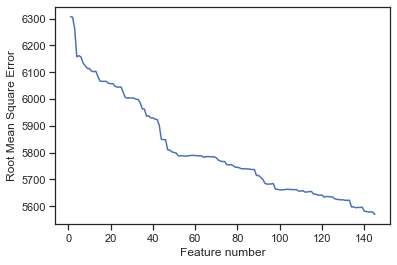

In [31]:
ax = sns.lineplot(x=np.arange(max_feature_num)+1, y=RMSEs)
ax.set_xlabel('Feature number')
ax.set_ylabel('Root Mean Square Error')
plt.show()

### Q14. 欠損値対応（2/2）：代表値補完
Q7では欠損値を含む行を削除することで，欠損値に対応をした（リストワイズ除去）．この方法は学習・評価に用いるデータ数が少なくなるという欠点がある．また，欠損値を含むデータに対する予測を行うことができない．この問題に対応するために，欠損値をそれを含む列のデータの中央値で埋め，再度線形回帰モデルの学習・評価を行え．

In [32]:
# 外れ値の除去
listing_df_v8 = remove_price_outliers(listing_df_v4)

In [33]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

# 外れ値除くのを忘れていた
listing_df_v9 = pd.DataFrame(imputer.fit_transform(listing_df_v8),
                             columns=listing_df_v8.columns, index=listing_df_v8.index)

In [34]:
# Cross Validation で検証する
X = listing_df_v9.drop('price', axis=1).values
y = listing_df_v9['price'].values

linear_regressor = LinearRegression()
scores = cross_validate(linear_regressor, X, y, cv=k_fold, scoring=score_funcs)

# 得られた指標を出力する
print('MAE =', np.mean(scores['test_MAE']))
print('RMSE =', np.mean(scores['test_RMSE']))

MAE = 4405.26649668923
RMSE = 19636.821358163892


### Q15. 総合課題
学習モデル，特徴量設計，欠損値・外れ値処理などを工夫して，1泊あたりの宿泊費``price``をより高い精度で予測する回帰モデルを構築せよ．

In [35]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(n_jobs=-1)

# Cross Validation で検証する
scores = cross_validate(rf_regressor, X, y, cv=k_fold, scoring=score_funcs)

# 得られた指標を出力する
print('MAE =', np.mean(scores['test_MAE']))
print('RMSE =', np.mean(scores['test_RMSE']))

MAE = 2752.4841173633954
RMSE = 4345.87150363015


---
### 参考資料
#### データセット
* http://insideairbnb.com/tokyo/

#### 分析
* [Exploring & Machine Learning for Airbnb Listings in Toronto](https://towardsdatascience.com/exploring-machine-learning-for-airbnb-listings-in-toronto-efdbdeba2644)
* [Predicting Airbnb prices with machine learning and location data](https://towardsdatascience.com/predicting-airbnb-prices-with-machine-learning-and-location-data-5c1e033d0a5a)
* [Airbnb Price Prediction Using Linear Regression (Scikit-Learn and StatsModels)](https://towardsdatascience.com/airbnb-price-prediction-using-linear-regression-scikit-learn-and-statsmodels-6e1fc2bd51a6)


#### データ加工
* [Pandas convert a column of list to dummies](https://stackoverflow.com/questions/29034928/pandas-convert-a-column-of-list-to-dummies)

#### 特徴選択

* [特徴量選択の今と新展開](https://aotamasaki.hatenablog.com/entry/2019/02/10/130647)
* [変数選択(Feature Selection)手法のまとめ](https://aotamasaki.hatenablog.com/entry/2018/04/18/201127)
* [特徴量選択のまとめ - Qiita](https://qiita.com/shimopino/items/5fee7504c7acf044a521)
* [特徴量選択について - Qiita](https://qiita.com/fhiyo/items/33b295de64f5a6a047c6)